# minimum mean square 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

import pymc3 as pm
import theano
import theano.tensor as tt

#  Slice sampling code

In [83]:
def myModel(theta, x):
    m, c = theta 
    return( x*m + c)


def myLoglike(theta,x,data,sigma):
    model = myModel(theta,x)
    return( -(0.5/sigma**2)*np.sum((data-model)**2))

In [76]:
'''
Wrapper class
'''
# define a theano Op for our likelihood function
class LogLike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [35]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise

x = np.linspace(0., 9., N)


mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = myModel([mtrue, ctrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma*np.random.randn(N) + truemodel


In [37]:
ndraws = 3000  # number of draws from the distribution
nburn = 1000   # number of "burn-in points" (which we'll discard)

# create our Op
logl = LogLike(myLoglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model() as model:
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={"v":theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains, 0 divergences:  12%|█▏        | 982/8000 [00:02<00:16, 437.65draws/s]


ValueError: Not enough samples to build a trace.

#  custom NUTS usage 

In [74]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import arviz as az
import daft
import theano
theano.config.warn.round=False

In [69]:
n = 100
heads = 61

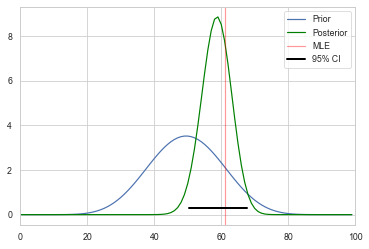

In [72]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), c='green', label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()

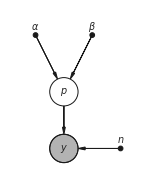

In [75]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()

In [80]:
def logp(x, mu=0, sigma=1):
    """Normal distribtuion."""
    return -0.5*np.log(2*np.pi) - np.log(sigma) - (x-mu)**2/(2*sigma**2)


In [81]:
niter = 1000
with pm.Model() as prior_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.DensityDist('y', logp, observed=dict(x=xs, mu=mu, sigma=sd))
    custom_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 678.66draws/s]
